# QAOA for Graph Partitioning with Qiskit and Quri-Parts
## What is the graph partitioning problem?

The graph partitioning problem is the problem of dividing a graph 
𝐺 with 𝑉 vertices into two parts in such a way that the number of edges cut is minimized. For example, consider a graph with 6 vertices like the following.

![init_graph](graph_partition_fig/graph_init.png)

If we divide this into halves with 3 vertices each, it would be divided as follows,

![colored_graph](graph_partition_fig/graph_colored.png)

and one can see that the number of edges cut is minimized (in this case, two). 

It is known that finding this solution is NP-hard.

## Expressing the graph partitioning problem using a mathematical model

Suppose there is graph $G=(V,E)$, where $V$ is the set of vertices and $E$ is the set of edges. We consider dividing this into two sets, $V_1$ and $V_2$. To formulate the problem, a variable $x_u$ is introduced. This variable is equal to 1 if vertex $x_u$ belongs to $V_1$, and 0 if it belongs to in $V_2$.

In this case, the objective function to be minimized can be expressed as follows.

$$
\mathrm{min}\sum_{(uv)\in E} (\{x_u(1-x_v) + x_v(1-x_u)\})
$$

Here, the term $x_u(1-x_v)$ represents an edge connecting $V_1$ and $V_2$. For example, if $x_u$ belongs to $V_1$, it is 1, and if $x_v$ belongs to $V_2$, it is 0. In such a case, the edge specified by $u$ and $v$ connects $V_1$ and $V_2$, and $x_u(1-x_v)$ becomes 1.

The term $x_v(1-x_u)$ is similar. If we sum this over the edges in $G$, $\sum_{(uv)\in E}$, we can represent the number of edges connecting $V_1$ and $V_2$.

Moreover, the constraint that the vertices of $G$ are evenly divided between $V_1$ and $V_2$ can be written as the following equation.

$$
\sum_{u\in V}x_u=V/2
$$

Let’s formulate the problem as described above using JijModeling, convert it into various quantum algorithms using Qamomile, and solve it.

## Importing Packages

In [1]:
import qamomile.core as qm
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import networkx as nx
import matplotlib.pyplot as plt
import random

## Formulation using JijModeling
Now that everything is ready, let's first model the problem using JijModeling.

In [2]:
#Formulating the problem
problem = jm.Problem('Graph Partitioning')

#Defining Variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
x = jm.BinaryVar('x', shape=(V,))
u = jm.Element('u', belong_to=V)
e = jm.Element('e', belong_to=E)

#Formulating the constraint
const = jm.sum(u, x[u])
problem += jm.Constraint('constraint', const==V/2)

#Formulating the objective function
A_1 = x[e[0]]*(1-x[e[1]])
A_2 = (1-x[e[0]])*x[e[1]]
problem += jm.sum(e, (A_1 + A_2))

This completes the modeling. Let's display the created model.

In [3]:
problem

## Preparing the problem
We will now prepare the problem to be solved. Here, we will create it using a random graph

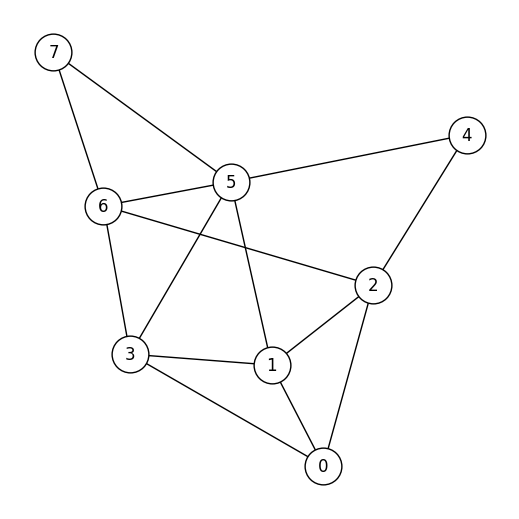

In [4]:
#Parameters
num_nodes = 8  #Number of vertices
edge_probability = 0.5  #Edge addition probability

#Creating a random graph
def generate_random_graph(num_nodes, edge_probability):
    G = nx.Graph()
    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add edges randomly
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < edge_probability:
                G.add_edge(i, j)

    return G

G = generate_random_graph(num_nodes, edge_probability)

#Visualization of the created random graph
def plot_graph(G):
    pos = nx.spring_layout(G,seed=1)
    plt.figure(figsize=(5,5))
    nx.draw(G, pos, with_labels=True, node_color='white', node_size=700,
           edgecolors='black')
    plt.show()

plot_graph(G)

We will prepare the problem data in a format that can be used with the model created in JijModeling

In [5]:
inst_E = [list(edge) for edge in G.edges]
instance_data = {"V": num_nodes,"E": inst_E}
num_qubits = num_nodes

## Creating a Compiled Instance

A compiled instance is an intermediate representation where actual values are substituted into the constants of the mathematical expressions. Before converting to various algorithms, it is necessary to first create this compiled instance.

In [6]:
compiled_instance = jmt.compile_model(problem, instance_data)

## Generation of QAOA Circuit and Hamiltonian Using Qamomile
Qamomile provides a converter that generates circuits and Hamiltonians for QAOA from the compiled instance. Additionally, it allows setting parameters that arise during the conversion to QUBO.

First, we will generate the Ising Hamiltonian. Once this is done, we can also generate the quantum circuit and Hamiltonian for QAOA.








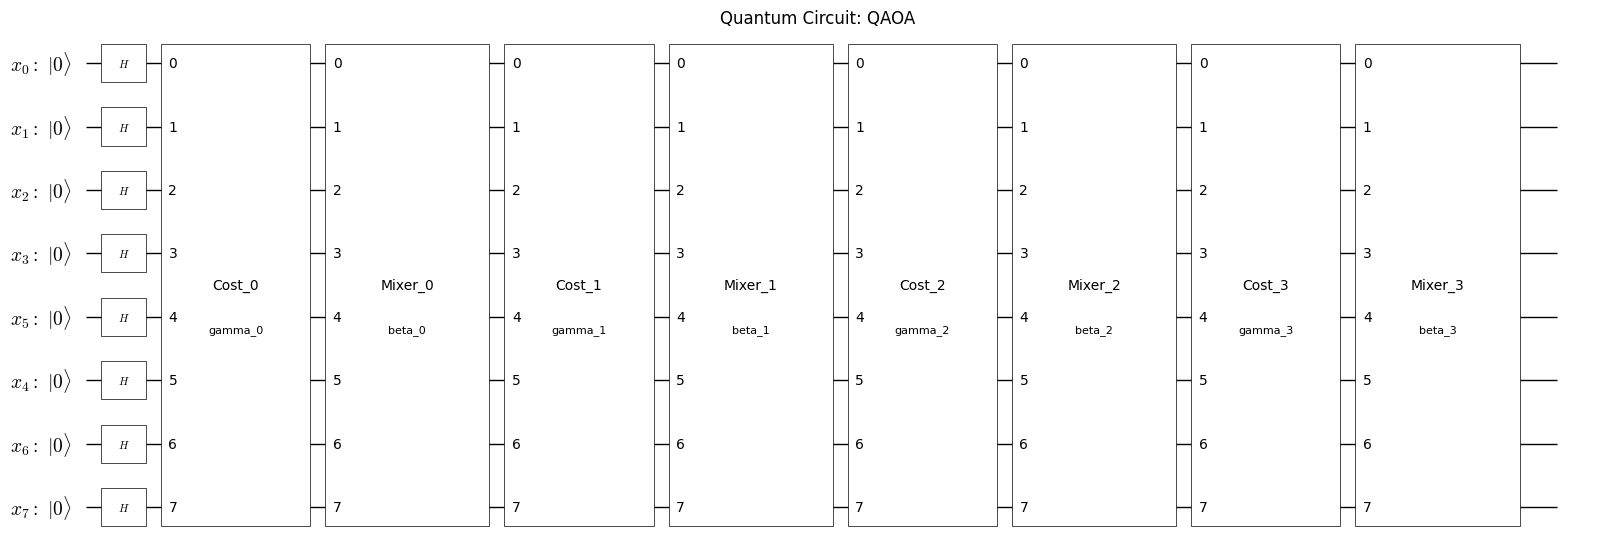

In [7]:
from qamomile.core.circuit.drawer import plot_quantum_circuit
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)

# Encode to Ising Hamiltonian
qaoa_converter.ising_encode()

# Get the QAOA circuit
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=4) #p is the number of layers 
plot_quantum_circuit(qaoa_circuit) #print it out
# Get the cost Hamiltonian
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

## Converting the Obtained Circuit and Hamiltonian for Qiskit
Qamomile has its own representation of quantum circuits and Hamiltonians to support multiple quantum algorithms. These representations need to be converted for use in the desired quantum libraries.

As of the time of writing this document (August 21, 2024), Qamomile supports:
- Qiskit
- Quri-Parts

As an example, let's first convert the circuit and Hamiltonian for Qiskit. To do this, we will first create an instance of __QiskitTranspiler__. Using the methods __transpile_circuit__ and __transpile_hamiltonian__ from this class, we can generate the quantum circuit and Hamiltonian.

In [8]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()

# Creating the circuit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)

#Creating the Hamiltonian
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian #print it out

SparsePauliOp(['IIZIIIIZ', 'IIIZIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIIZIZII', 'ZIIIIZII', 'IIZIZIII', 'ZIIIZIII', 'IZZIIIII', 'ZIZIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])

## Running QAOA
Now that everything is ready, let's run QAOA. Here, we are using Scipy's COBYLA as the optimization algorithm.

In [9]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

initial_params = [np.pi / 4, np.pi / 2, np.pi / 2, np.pi / 4,np.pi / 4, np.pi / 2, np.pi / 2, np.pi / 4]

# Run QAOA optimization
result = minimize(
    cost_estimator,
    initial_params,
    method="COBYLA",
    options={"maxiter": 100},
)
print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.8623413812989711
       x: [ 1.912e+00  1.550e+00  1.637e+00  6.945e-01  6.068e-01
            1.336e+00  1.239e+00  3.770e-01]
    nfev: 100
   maxcv: 0.0


Let's also take a look at the changes in the cost function

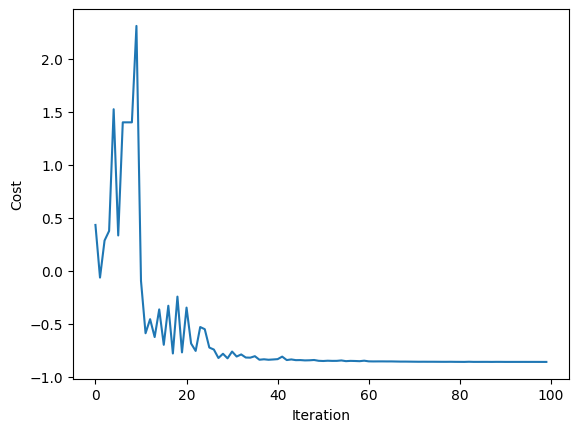

In [10]:
import matplotlib.pyplot as plt

# plt.yscale("log")
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Now we have obtained the QAOA parameters. Let's use them for sampling

In [11]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]
qaoa_counts.get_counts()

{'00110101': 4,
 '00111110': 16,
 '00110110': 58,
 '01100101': 13,
 '10001010': 25,
 '10100001': 24,
 '11001001': 60,
 '10110100': 7,
 '11011001': 14,
 '00100110': 4,
 '00111000': 8,
 '10110001': 2,
 '01001000': 7,
 '01011110': 27,
 '11110101': 22,
 '11100001': 50,
 '10100011': 8,
 '10010010': 3,
 '00011110': 48,
 '11001011': 17,
 '01011010': 7,
 '01110101': 22,
 '11111010': 1,
 '10000011': 6,
 '00101011': 15,
 '00011010': 8,
 '11011011': 4,
 '00110100': 18,
 '10000110': 3,
 '00101000': 7,
 '11000011': 4,
 '11100101': 14,
 '11010000': 2,
 '01111100': 5,
 '01001010': 7,
 '00110111': 16,
 '10110101': 13,
 '01110100': 7,
 '11000001': 16,
 '00101010': 13,
 '00010100': 1,
 '00010110': 9,
 '00111111': 2,
 '01001101': 3,
 '10101001': 7,
 '11011000': 11,
 '10110000': 5,
 '10011010': 11,
 '11010101': 21,
 '01001011': 9,
 '00100101': 2,
 '10011000': 2,
 '00001011': 4,
 '00001010': 22,
 '00100111': 25,
 '10010110': 12,
 '01010110': 12,
 '10111000': 3,
 '11010111': 4,
 '00100010': 2,
 '11000111': 

## Evaluating the Results
To evaluate the solution, it is convenient to use the sample_set. It calculates the objective function value, constraint violations, and more from the obtained solution.

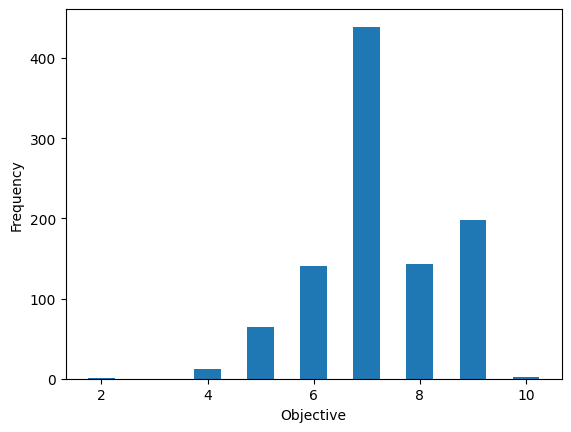

In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

# Initialize a dictionary to accumulate occurrences for each energy value
frequencies = defaultdict(int)

# Define the precision to which you want to round the energy values
for sample in sampleset:
    energy = round(sample.eval.objective, ndigits = 3)  
    frequencies[energy] += sample.num_occurrences

plt.bar(frequencies.keys(), frequencies.values(), width=0.5)
plt.xlabel('Objective')
plt.ylabel('Frequency')
plt.show()

The value of the objective function represents the number of edges connecting $V_1$ and $V_2$, so the pattern with the smallest value can be considered the solution. Let's plot the obtained results on a graph.


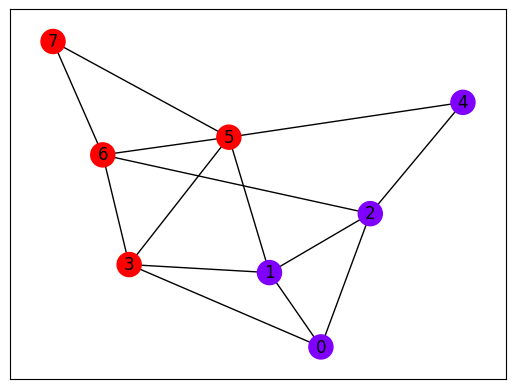

In [13]:
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.SampleSet):
    # extract feasible solution
    lowests = sampleset.lowest()
    
    if len(lowests) == 0:
        print("No feasible solution found ...")
    else:
        best_sol = lowests[0]
        pos = nx.spring_layout(graph,seed=1)

        color_map = []
        for node in graph.nodes:
            if (node,) in best_sol.var_values["x"].values.keys():
                color_value = best_sol.var_values["x"].values[(node,)]
                color_map.append(color_value)
            else:
                color_map.append(0)  # Default color if not in the solution

        # Draw the graph with the color mapping
        nx.draw_networkx(graph, pos, with_labels=True,
                         node_color=color_map, cmap=plt.get_cmap('rainbow'))

plot_graph_coloring(G, sampleset)

## Conversion to Quri-Parts using Qamomile
Next, let's perform the conversion for Quri-Parts. First, we will import the necessary libraries

In [14]:
from qamomile.quri_parts import QuriPartsTranspiler


We will perform the conversion in the same way as with Qiskit

In [15]:
quri_transpiler = QuriPartsTranspiler()
quri_circuit = quri_transpiler.transpile_circuit(qaoa_circuit)
quri_hamiltonian = quri_transpiler.transpile_hamiltonian(qaoa_hamiltonian)


We will set the parameters and perform optimization

In [16]:
from quri_parts.core.state import quantum_state, apply_circuit

cb_state = quantum_state(quri_circuit.qubit_count, bits=0)
parametric_state = apply_circuit(quri_circuit, cb_state)

Quri-Parts with Qulacs is a quantum circuit simulator that operates faster than Qiskit. Taking advantage of this superior speed, let's increase the number of iterations in our experiment. By doing so, we can potentially improve our results even further and explore the capabilities of Quri-Parts more deeply. Let's modify our code to run more iterations and see how this affects our sampling results and the frequency of obtaining the lowest objective value.

In [17]:
from typing import Sequence
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator

estimator = create_qulacs_vector_parametric_estimator()

cost_history = []
def cost_fn(param_values: Sequence[float]) -> float:
    estimate = estimator(quri_hamiltonian, parametric_state, param_values)
    cost = estimate.value.real
    cost_history.append(cost)
    return cost


result = minimize(cost_fn, initial_params, method="COBYLA", options={"maxiter": 500})
result

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.428018010511478
       x: [ 4.807e-01  2.911e+00  2.687e+00  1.511e+00  9.689e-01
            1.595e+00  1.338e+00  2.436e-01]
    nfev: 500
   maxcv: 0.0

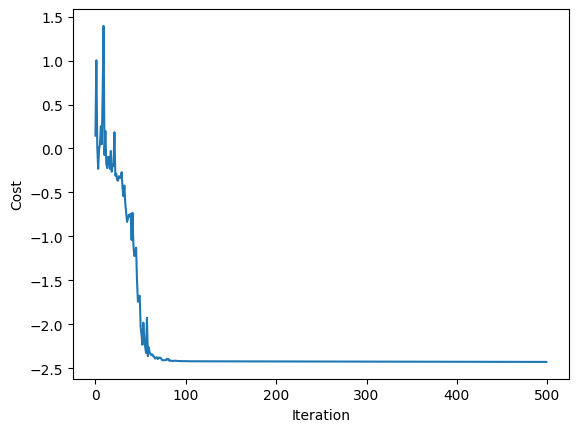

In [18]:
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

If the cost function appears to have sufficiently decreased, we will use the obtained parameters to sample the solution

In [19]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler

sampler = create_qulacs_vector_sampler()
bounded_circuit = quri_circuit.bind_parameters(result.x)
qp_result = sampler(bounded_circuit, 1000)

Let's visualize the sampling results

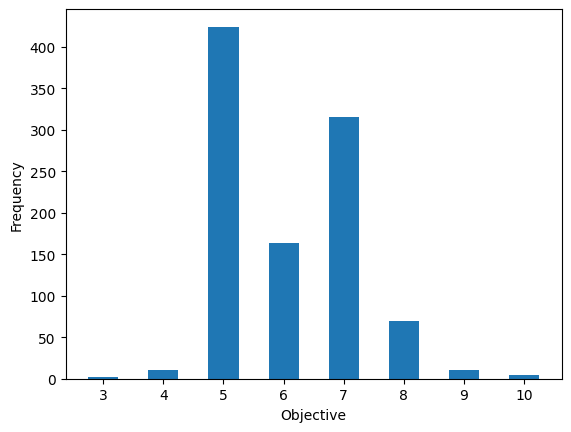

In [20]:
sampleset = qaoa_converter.decode(quri_transpiler, (qp_result, quri_circuit.qubit_count))

# Initialize a dictionary to accumulate occurrences for each energy value
frequencies = defaultdict(int)

# Define the precision to which you want to round the energy values
for sample in sampleset:
    energy = round(sample.eval.objective, ndigits = 3)  
    frequencies[energy] += sample.num_occurrences

plt.bar(frequencies.keys(), frequencies.values(), width=0.5)
plt.xlabel('Objective')
plt.ylabel('Frequency')
plt.show()

Let's plot the obtained results

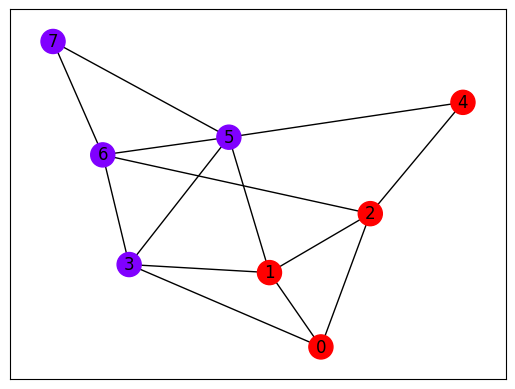

In [21]:
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.SampleSet):
    # extract feasible solution
    lowests = sampleset.lowest()
    if len(lowests) == 0:
        print("No feasible solution found ...")
    else:
        best_sol = lowests[0]
        pos = nx.spring_layout(graph,seed=1)

        color_map = []
        for node in graph.nodes:
            if (node,) in best_sol.var_values["x"].values.keys():
                color_value = best_sol.var_values["x"].values[(node,)]
                color_map.append(color_value)
            else:
                color_map.append(0)  # Default color if not in the solution

        # Draw the graph with the color mapping
        nx.draw_networkx(graph, pos, with_labels=True,
                         node_color=color_map, cmap=plt.get_cmap('rainbow'))

plot_graph_coloring(G, sampleset)